In [1]:
import numpy as np
import time
from sklearn.externals import joblib
from sklearn import model_selection
import itertools
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics


from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from Sonar import StackedAutoEncoderCV as SAE

np.set_printoptions(3)

base_filename = '../Models/iris_sae_CLASS.jbl'

/Users/ciodaro/.virtualenvs/sonar/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


# Load Data 

In [22]:
dataset = datasets.load_iris()
data = dataset.data
target = dataset.target
class_names = dataset['target_names']

# Novelty Definition 

In [23]:
nov_cls = 0
nov_data = data[target == nov_cls]
nov_target = target[target == nov_cls]
nov_name = class_names[nov_cls]
# Known data
data = data[target != nov_cls]
target = target[target != nov_cls]
if np.unique(target).shape[0] == 2:
    one_hot_target = np.ones([target.shape[0],1])
    one_hot_target[target == np.unique(target)[1], 0] = -1
else:
    one_hot_target = -np.ones([target.shape[0], np.unique(target).shape[0]])
    for i, cls in enumerate(np.unique(target)):
        one_hot_target[target == cls, i] = 1
class_names = np.setdiff1d(class_names, [nov_name])

# Load Models 

In [24]:
autoencoders = {}
encoders = {}
for cls in class_names:
    sae = SAE.StackedAutoEncoderCV()
    sae.load(base_filename.replace('CLASS', cls))
    autoencoders[cls] = sae.network
    encoders[cls] = sae.network.get_encoder()

Loading from  ../Models/iris_sae_versicolor.jbl
Loading from  ../Models/iris_sae_virginica.jbl


# Add Output Classification Layer 

In [25]:
common_input = layers.Input(shape = [data.shape[1]])
graph_a = common_input
for lay in encoders['virginica'].layers:
    lay.name = 'virginica_' + lay.name
    lay.trainable = False
    graph_a = lay(graph_a)
graph_b = common_input
for lay in encoders['versicolor'].layers:
    lay.name = 'versicolor_' + lay.name
    lay.trainable = False
    graph_b = lay(graph_b)

merge_layer = layers.concatenate([graph_a, graph_b], axis=1)
hidden_layer = layers.Dense(10, activation='tanh')(merge_layer)
out_layer = layers.Dense(one_hot_target.shape[1], activation='tanh')(hidden_layer)
new_model = models.Model(inputs=[common_input], outputs=out_layer)
opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
new_model.compile(loss='mean_squared_error', optimizer=opt)

trn_desc = new_model.fit(data, one_hot_target, 
                         epochs = 200, 
                         batch_size = 100,
                         verbose = False,
                         shuffle=False)

In [13]:
class_names

array(['versicolor', 'virginica'], dtype='|S10')

In [26]:
clsname = 'versicolor'
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 1]), data[target == 1])
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 2]), data[target == 2])
print metrics.mean_squared_error(autoencoders[clsname].predict(nov_data), nov_data)

0.03695653870967398
0.3851044953470487
1.9515768678239573


In [27]:
clsname = 'virginica'
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 1]), data[target == 1])
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 2]), data[target == 2])
print metrics.mean_squared_error(autoencoders[clsname].predict(nov_data), nov_data)

0.354150642660116
0.05558743457556734
4.09410697269849


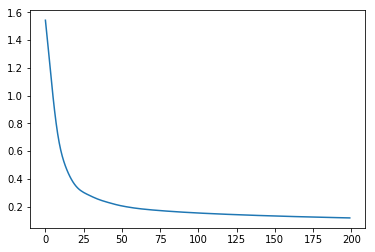

In [28]:
plt.plot(trn_desc.epoch, trn_desc.history['loss'], '-')

In [29]:
Y = new_model.predict(data)
print metrics.confusion_matrix(np.argmax(Y, axis=1), np.argmax(one_hot_target, axis=1))
print metrics.classification_report(np.argmax(Y, axis=1), np.argmax(one_hot_target, axis=1))

[[100]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00       100



Class
Novelty    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Output, dtype: object

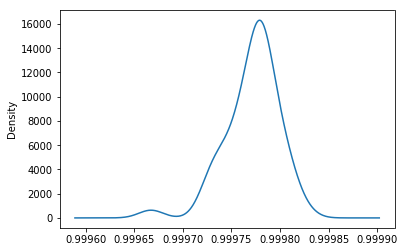

In [32]:
df_nov.groupby('Class').Output.plot(kind='kde')

(-1, 1)

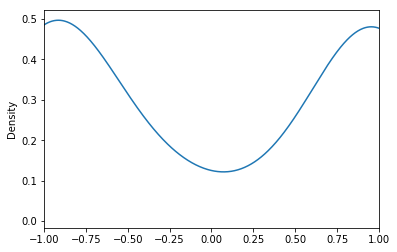

In [34]:
df_known.groupby('Class').Output.plot(kind='kde')
plt.xlim((-1, 1))

Class
Known      AxesSubplot(0.125,0.125;0.775x0.755)
Novelty    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Output, dtype: object

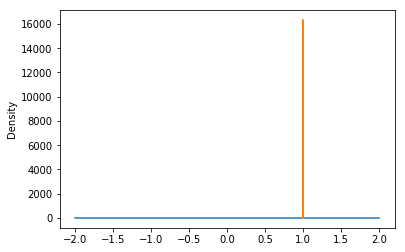

In [31]:
Y = new_model.predict(nov_data)
Y = np.max(Y, axis=1)

import pandas
df_known = pandas.DataFrame(columns=['Class','Output'])
df_known['Output'] = np.max(new_model.predict(data), axis=1)
df_known['Class'] = 'Known'
df_nov = pandas.DataFrame(columns=['Class','Output'])
df_nov['Output'] = np.max(new_model.predict(nov_data), axis=1)
df_nov['Class'] = 'Novelty'
df = pandas.concat((df_known, df_nov), axis=0)

df.groupby('Class').Output.plot(kind='kde')